In [ ]:
# default_exp data
%load_ext lab_black
# nb_black if running in jupyter
%load_ext autoreload
# automatically reload python modules if there are changes in the
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

# Data

> (Generate*), load and clean data

*to avoid privacy issues we generate new data, similar to real customer data we have. You may replace this with customer path data of your own. 

***input***: raw data

***output***: clean and tidy dataset + toy dataset for testing

***description:***

In this notebook we generate customer path data, and transform it into tensorflow federated [ClientData](https://www.tensorflow.org/federated/tutorials/working_with_client_data) format.
You can edit the code to load and clean and transform your own client path data.

## Import relevant modules

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import softmax
from seaborn import heatmap

# your code here

## Define notebook parameters

Define input, output and additional parameters of this notebook, the information needed for running the notebook.
In your own project, you can do this step in the later iterations of the work,
when you know what is required.
In this cell, only assing values to variables directly: `variable_name = value`.
**Do not derive any information in this cell as it will mess up the parameterization** - do it in the cell below.

In [ ]:
# This cell is tagged with 'parameters'
seed = 0
# your code here

Define any immediate derivative operations from the parameters:

In [ ]:
# set seed
np.random.seed(seed)
# your code here

## Generate data (from a Markov Process)

Our decired data point is a transition between two customer sevice states for a customer.
The feature is the previous service state, and the label is the following service state.

We need to simulate imaginary customer paths trough markov process modelling.

In our example we have one incoming state 'begin', and one absorbing state 'end'.
The customer is in the beginning state before the first service event.
In the between there are X service states that the customer can encounter.
After the last observed service state the customer is moved to 'end' state. 
You are free to apply different assumptions.

For example we could include information on the incoming state: is it the frontpage of the service, another website, social media etc. 

In [ ]:
# state space
S = np.array(
    [
        "begin",
        "search",
        "scrolling",
        "view",
        "chatbot",
        "customer_service",
        "shopping_cart",
        "purchace",
        "end",
    ]
)
n_states = S.shape[0]

# transition matrix
# the actual values of the transition matrix do not matter, so we just generate random.
# the ML algorithms should be able to learn whatever relations
P = np.hstack(
    (
        np.zeros((n_states, 1)),  # cannot reach begin state afterwards
        softmax(np.random.uniform(size=(n_states, n_states - 1)), axis=1),
    )
)  # randomly set other transition states
P[-1, :] = 0
P[-1, -1] = 1  # the absorbing state

assert np.count_nonzero(P.sum(axis=0) - 1) == n_states

Text(0.5, 1.0, 'Transition matrix')

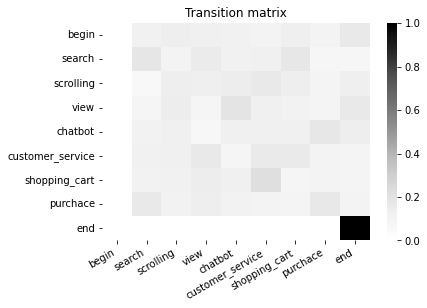

In [ ]:
g = heatmap(P, cmap="Greys")
g.set_yticklabels(S, rotation=0)
g.set_xticklabels(S, rotation=30, va="top", ha="right")
g.set_title("Transition matrix")

Then, let's generate some customer paths

In [ ]:
n_customers = 1000  # number of customers (paths, assuming only one path per customer)
max_path_length = 100  # limit simulation length

# dataframe to store the results
df = pd.DataFrame(
    columns={"customer_id": int, "prev_state": np.uint8, "next_state": np.uint8}
)

# loop through customers
for customer_id in range(n_customers):
    prev_state = 0
    count = 0
    while prev_state != n_states - 1 and count < max_path_length:
        # select new state according to weights in transition matrix
        next_state = np.random.choice(np.arange(n_states), p=P[prev_state, :].flatten())
        df = df.append(
            {
                "customer_id": customer_id,
                "prev_state": prev_state,
                "next_state": next_state,
            },
            ignore_index=True,
        )
        prev_state = next_state
        count += 1

# check out results
df.head()

,customer_id,prev_state,next_state
0,0,0,8
1,1,0,6
2,1,6,6
3,1,6,1
4,1,1,2


plot histogram of path lengths

with one absorbing state, should decay exponentially: $y=e^{-ax+b}$

<AxesSubplot:>

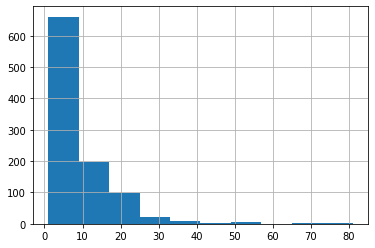

In [ ]:
df.groupby("customer_id").count()["prev_state"].hist()

## (or alternatively load your own data and turn it into the same format)

In [ ]:
# your code here

## Describe the data

Define data points, features and labels

In [ ]:
# your code here

## Visualize the data

In [ ]:
# your code here

# Convert into tff ClientData

In [ ]:
# your code here

## Save clean and tidy data for further use

In [ ]:
# your code here

## Create small toy dataset for developing and testing the ML methods

In [ ]:
# your code here

save the toy dataset:

In [ ]:
# your code here

## You can now move on to the model notebook!